## Imports

In [1]:
import torch
import torch.nn.parallel
import torch.utils
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
from PIL import Image
import DrawingWithTensors
import math
import os
import sys

from torchvision.transforms import ToPILImage
#from IPython.display import Image
#to_img = ToPILImage()
#from IPython.display import Image

#plt.ion()   # interactive mode

#original code for training: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

#original paths for FCNs:
#/home/peo5032/data/models/chainer/fcn16s_from_caffe.npz
# calling torchfcn.models.FCN16s.pretrained_model yields:
# might need to call download on it first: torchfcn.models.FCN16s.download()
#'/home/peo5032/data/models/pytorch/fcn16s_from_caffe.pth'

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import argparse

# initiate the parser
parser = argparse.ArgumentParser(description = "List of options to run application when creating custom datset")

parser = argparse.ArgumentParser()  
parser.add_argument("-V", "--version", help="show program version", action="store_true")
parser.add_argument("-b", "--batch", help="batch size in each epoch")
parser.add_argument("-e", "--epoch", help="number of epochs for training")
parser.add_argument("-r", "--root_folder", help="destination for root folder")
parser.add_argument("-i", "--iteration", help="which generation number we are using")
parser.add_argument("-t", "--training", help="true/false to start with new Unet weights")
parser.add_argument("-w", "--weights", help="full path to save weights")
parser.add_argument("-c", "--pickup", help="full path to resume training use weights")
parser.add_argument("-p", "--picture", help="picture dimensions")
parser.add_argument("-d", "--dataset", help="root directory of dataset folder")

_StoreAction(option_strings=['-d', '--dataset'], dest='dataset', nargs=None, const=None, default=None, type=None, choices=None, help='root directory of dataset folder', metavar=None)

In [3]:
PRETRAINED_PATH = '/home/peo5032/data/models/pytorch/fcn16s_from_caffe.pth'

NUM_CLASSES = 1
EPOCHS = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
imageSize = 416
batchSize = 1
iteration = "1"
newTraining = False

#change values if user specifies non-default values
#'-t','True','-i','2','-e','325','-b','1', '-w', '/home/peo5032/Documents/COMP594/model2.pt', '-p','416'
#args = parser.parse_args(['-i','2','-e','39500','-b','1', '-w', '/home/peo5032/Documents/COMP594/model4.pt', '-p','416','-c','/home/peo5032/Documents/COMP594/bce/INTERRUPTED4.pt']
args = parser.parse_args(['-c','/home/peo5032/Documents/COMP594/input/gen5/bce/model5.pt','-i','5','-e','29900',
                          '-b','1', '-w', '/home/peo5032/Documents/COMP594/model5v2.pt', '-p','416'])

# check for --version or -V
if args.version:  
    print("this is version 0.1")
    
if args.batch: 
    print("batch size is set to", args.batch)
    batchSize = int(args.batch)

if args.epoch: 
    print("number of epochs is set to", args.epoch)
    EPOCHS = int(args.epoch)
    
if args.root_folder:  
    if os.path.exists(root_folder):
        ROOT = root_folder
    print("destination was", args.root_folder)
    
if args.iteration:
    print("iteration is set to", args.iteration)
    iteration = args.iteration

    
SAVE_LOCATION = "/home/peo5032/Documents/COMP594/input/gen"+iteration+"/model.pt"

if args.weights:
    print("save location is set to", args.weights)
    SAVE_LOCATION = args.weights
    
    
LOAD_LOCATION = "/home/peo5032/Documents/COMP594/input/gen"+iteration+"/model.pt"


if args.pickup:
    print("load location is set to", args.pickup)
    LOAD_LOCATION = args.pickup

    
data_dir = '/home/peo5032/Documents/COMP594/input/gen'+iteration

if args.dataset:
    print("loading dataset from ", args.dataset)
    data_dir = args.dataset
    
if args.training:
    if args.training.lower() == "true":
        print("new training is set to true")
        newTraining = True
        
if args.picture:
    print("picture size to train on is", args.picture)
    imageSize = int(args.picture)

batch size is set to 1
number of epochs is set to 29900
iteration is set to 5
save location is set to /home/peo5032/Documents/COMP594/model5v2.pt
load location is set to /home/peo5032/Documents/COMP594/input/gen5/bce/model5.pt
picture size to train on is 416


In [5]:
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
class DICELossMultiClass(torch.nn.Module):
 
    def __init__(self):
        super(DICELossMultiClass, self).__init__()
 
    def forward4(self, pred, targs):
        pred = (pred>0).float()
        return 2. * (pred*targs).sum() / (pred+targs).sum()
    
    #https://gist.github.com/weiliu620/52d140b22685cf9552da4899e2160183#file-dice_coeff_loss-py-L3
    def forward3(self, pred, target):
        """This definition generalize to real valued pred and target vector.
    This should be differentiable.
        pred: tensor with first dimension as batch
        target: tensor with first dimension as batch
        """

        smooth = .0000001

        # have to use contiguous since they may from a torch.view op
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()

        A_sum = torch.sum(tflat * iflat)
        B_sum = torch.sum(tflat * tflat)

        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
    
    
    #self implementation
    def forward2(self, input, target):
        #self.save_for_backward(input, target)
        eps = 0.0001
        #self.inter = torch.dot(input.view(-1), target.view(-1))
        self.inter = 2. * torch.dot(input.abs().view(-1), target.view(-1))
        self.union = torch.sum(torch.mul(input,input).abs()) + torch.sum(target) 

        t = self.inter / self.union.float()
        return 1-t
    
    # From: https://github.com/pytorch/pytorch/issues/1249
    def forward(self,input, target):
        input = torch.sigmoid(input)

        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection) /
                  (iflat.sum() + tflat.sum()))

## Load Data

In [7]:
data_transforms = transforms.Compose([transforms.Resize([imageSize,imageSize]),
                                      transforms.ToTensor()
                                     ])

# instantiate the dataset and dataloader
dataset = ImageFolderWithPaths(data_dir, transform=data_transforms) # our custom dataset
dataloaders = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle=False)

# iterate over data
#for inputs, labels, paths in dataloader:
#    # use the above variables freely
#    print(inputs, labels, paths)

#groundTruth = tensor
#label = tensor[0,0]
#path = tuple list, access each via path[index]

new_road_factory = DrawingWithTensors.datasetFactory(IMAGE_SIZE=416)

## Training Routine without Validation Steps

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=4):
    since = time.time()
    best_model = None
    best_loss = math.inf
    model.train()  # Set model to training mode
    for epoch in range(1,num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1), flush=True)
        print('-' * 10, flush=True)

        epoch_loss = 0
   
        #BATCH TUPLE
        inputs, labels, paths = next(iter(dataloaders))
        inputs.to(device)
        #print(inputs.size())
                
        #build ground-truth batch tensor
        for locations in paths:
            i = 0
            #dtype=torch.int64
            labels = torch.zeros(batchSize,NUM_CLASSES,imageSize,imageSize, dtype = torch.float32).to(device)
            labels[i] = torch.load(locations.replace(".png", ".pt").replace("roads", "tensor_values")) #manually fetch your own tensor values here somehow? 
            i += 1
            
        # forward
        # track history if only in train
        # TODO: ENSURE OUTPUTS AND GROUNDTRUTH ARE THE SAME
        with torch.set_grad_enabled(True):
            #build input-truth batch tensor
            outputs = model(inputs.to(device)).to(device)
            loss = criterion(outputs, labels) #ground truth comparison

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # backward + optimize 
            loss.backward()
            optimizer.step()
            
            # statistics
            epoch_loss += loss.item()
        
        print('Epoch finished', flush=True)
        #print("BCE: {}".format(epoch_loss), flush=True)
        print("dice: {}".format(epoch_loss), flush=True)
        #print('loss: {}'.format(epoch_loss), flush=True)

        #save best copy of  model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model, SAVE_LOCATION.replace("model", "model_best"))
        
    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), flush=True)

    #completed model
    torch.save(model,SAVE_LOCATION)
    return model

In [10]:
def showInferenceOnImage(img, tensor, class_label, threshold, classMap):
    IMAGE_SIZE = 416
    imgTMP = img.copy()
    imgMap = imgTMP.load()
    class_type_corresponding_channel = classMap[class_label]
    print("index for channel", class_label, ":", class_type_corresponding_channel)    
    for i in range(0, IMAGE_SIZE):
        for j in range(0, IMAGE_SIZE):
            if tensor[class_type_corresponding_channel, i,j] < threshold:
                #hide background and emphasize the places where the network thinks are "class type"
                imgMap[i,j] = (0,0,0)
        
    return imgTMP

## Load Pretrained Model Weights

In [ ]:
#imports related to UNet
from unet_models import *

if newTraining:
    model = UNet16(num_classes=1, num_filters=32, pretrained=True, is_deconv=True)
    
else:
    print("loading weights from", LOAD_LOCATION)
    model = torch.load(LOAD_LOCATION)
    
model = model.to(device)

In [ ]:
#item1 = torch.ones(1,30,2,2)
#item2 = torch.ones(1,30,2,2)

#crit = DICELoss()
#crit = torch.nn.BCEWithLogitsLoss()
#loss = crit(item1, item2)
#print(loss.item())

In [23]:
#torch.sigmoid(item1)

## Training and Results

In [ ]:
#criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.BCELoss()
#criterion = DiceCoeff()
criterion = DICELossMultiClass()

# Observe default choices, except using amsgrad version of Adam
optimizer_ft = optim.Adam(model.parameters(),amsgrad=True)

# Osscilate between high and low learning rates
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, 7)

try:
    model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

except KeyboardInterrupt:
    torch.save(model, SAVE_LOCATION.replace("model",'INTERRUPTED'))
    print('Saved interrupt', flush=True)

In [12]:
#Show results in meanwhile
img = Image.open("/home/peo5032/Documents/COMP594/input/gen5/roads/29995.png")
test_tensor = torch.load("/home/peo5032/Documents/COMP594/input/gen5/tensor_values/29995.pt").to(device)
inputs = torch.zeros(1,3, imageSize, imageSize).to(device)

test_tensor.size()
inputs[0] = transforms.ToTensor()(img)
outputs = model(inputs)

In [ ]:
outputs.size()

In [ ]:
outputs[0]

In [13]:
outputs[0][0][410]
#torch.sigmoid(outputs[0][0][410])

tensor([4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086, 4.3086,
        4.3086, 4.3086, 4.3086, 4.3086, 

In [ ]:
#new_road_factory.classMap

In [14]:
print("min", torch.min(outputs[0]), "max", torch.max(outputs[0]))

min tensor(-1212.7280, device='cuda:0', grad_fn=<MinBackward1>) max tensor(4.3086, device='cuda:0', grad_fn=<MaxBackward1>)


In [15]:
print("min", torch.min(torch.sigmoid(outputs[0])), "max", torch.max(torch.sigmoid(outputs[0])))

min tensor(0., device='cuda:0', grad_fn=<MinBackward1>) max tensor(0.9867, device='cuda:0', grad_fn=<MaxBackward1>)


index for channel road : 0


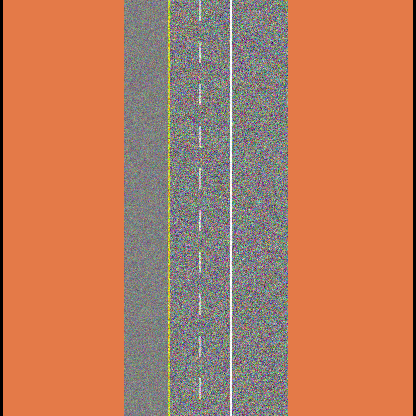

In [17]:
class_label = "road"
classMap = new_road_factory.classMap
threshold = 0.6
showInferenceOnImage(img, torch.sigmoid(outputs[0]), class_label, threshold, classMap)
#showInferenceOnImage(img, test_tensor, class_label, threshold, classMap)